#  Logistic Regression and Classification Error Metrics

Estudante: Lorena Gomes de Oliveira Cabral (20183002361)

## Introduction

We will be using the [Human Activity Recognition with Smartphones](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones) database, which was built from the recordings of study participants performing activities of daily living (ADL) while carrying a smartphone with an embedded inertial sensors. The objective is to classify activities into one of the six activities (walking, walking upstairs, walking downstairs, sitting, standing, and laying) performed.

For each record in the dataset it is provided: 

- Triaxial acceleration from the accelerometer (total acceleration) and the estimated body acceleration. 
- Triaxial Angular velocity from the gyroscope. 
- A 561-feature vector with time and frequency domain variables. 
- Its activity label. 

More information about the features is available on the website: above or at https://www.kaggle.com/uciml/human-activity-recognition-with-smartphones 

In [1]:
from __future__ import print_function
import os
#Data Path has to be set as per the file location in your system
#data_path = ['..', 'data']
data_path = ['data']

## Question 1

Import the data and do the following:

* Examine the data types--there are many columns, so it might be wise to use value counts
* Determine if the floating point values need to be scaled
* Determine the breakdown of each activity
* Encode the activity label as an integer

In [2]:
import pandas as pd
import numpy as np
#The filepath is dependent on the data_path set in the previous cell 
filepath = os.sep.join(['Human_Activity_Recognition_Using_Smartphones_Data.csv'])
data = pd.read_csv(filepath, sep=',')

The data columns are all floats except for the activity label.

In [3]:
data.dtypes.value_counts()

float64    561
int64        1
object       1
Name: count, dtype: int64

In [4]:
data.dtypes.tail()

angle(X,gravityMean)    float64
angle(Y,gravityMean)    float64
angle(Z,gravityMean)    float64
subject                   int64
Activity                 object
dtype: object

The data are all scaled from -1 (minimum) to 1.0 (maximum).

In [5]:
data.iloc[:, :-1].min().value_counts()

-1.000000    466
-0.995377      2
-0.999996      2
-0.999893      2
-1.000000      2
            ... 
-0.999983      1
-0.943439      1
-0.998014      1
-0.999915      1
 1.000000      1
Name: count, Length: 93, dtype: int64

In [6]:
data.iloc[:, :-1].max().value_counts()

1.000000     452
0.994731       2
0.805064       1
0.908361       1
0.891736       1
            ... 
0.990935       1
0.979031       1
0.928416       1
0.848031       1
30.000000      1
Name: count, Length: 110, dtype: int64

Examine the breakdown of activities--they are relatively balanced.

In [7]:
data.Activity.value_counts()

Activity
LAYING                1407
STANDING              1374
SITTING               1286
WALKING               1226
WALKING_UPSTAIRS      1073
WALKING_DOWNSTAIRS     986
Name: count, dtype: int64

Scikit learn classifiers won't accept a sparse matrix for the prediction column. Thus, either `LabelEncoder` needs to be used to convert the activity labels to integers, or if `DictVectorizer` is used, the resulting matrix must be converted to a non-sparse array.  
Use `LabelEncoder` to fit_transform the "Activity" column, and look at 5 random values.

In [8]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
data['Activity'] = le.fit_transform(data.Activity)
data['Activity'].sample(5)

6667    1
5992    3
3252    2
2425    1
1430    4
Name: Activity, dtype: int64

## Question 2

* Calculate the correlations between the dependent variables.
* Create a histogram of the correlation values
* Identify those that are most correlated (either positively or negatively).

In [9]:
# Calculate the correlation values
feature_cols = data.columns[:-1]
corr_values = data[feature_cols].corr()

# Simplify by emptying all the data below the diagonal
tril_index = np.tril_indices_from(corr_values)

# Make the unused values NaNs
for coord in zip(*tril_index):
    corr_values.iloc[coord[0], coord[1]] = np.NaN
    
# Stack the data and convert to a data frame
corr_values = (corr_values.stack().to_frame().reset_index().rename(columns={'level_0':'feature1','level_1':'feature2',0:'correlation'}))

# Get the absolute values for sorting
corr_values['abs_correlation'] = corr_values.correlation.abs()

A histogram of the absolute value correlations.

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

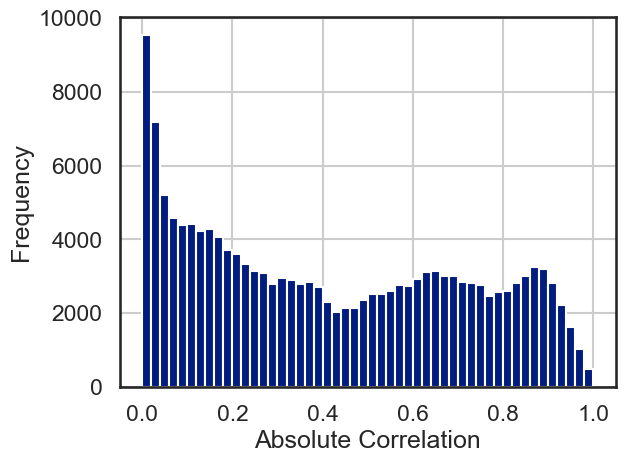

In [11]:
sns.set_context('talk')
sns.set_style('white')
sns.set_palette('dark')

ax = corr_values.abs_correlation.hist(bins=50)

ax.set(xlabel='Absolute Correlation', ylabel='Frequency');

In [12]:
# The most highly correlated values
corr_values.sort_values('correlation', ascending=False).query('abs_correlation>0.8')

,feature1,feature2,correlation,abs_correlation
94102,tBodyAccMag-sma(),tGravityAccMag-mean(),1.000000,1.000000
96228,tBodyAccMag-arCoeff()3,tGravityAccMag-arCoeff()3,1.000000,1.000000
94818,tBodyAccMag-iqr(),tGravityAccMag-iqr(),1.000000,1.000000
93033,tBodyAccMag-mad(),tGravityAccMag-mad(),1.000000,1.000000
94107,tBodyAccMag-sma(),tGravityAccMag-sma(),1.000000,1.000000
...,...,...,...,...
22698,tGravityAcc-mean()-Y,"angle(Y,gravityMean)",-0.993502,0.993502
39300,"tGravityAcc-arCoeff()-Z,3","tGravityAcc-arCoeff()-Z,4",-0.994256,0.994256
38813,"tGravityAcc-arCoeff()-Z,2","tGravityAcc-arCoeff()-Z,3",-0.994684,0.994684
23218,tGravityAcc-mean()-Z,"angle(Z,gravityMean)",-0.995070,0.995070


## Question 3

* Split the data into train and test data sets. This can be done using any method, but consider using Scikit-learn's `StratifiedShuffleSplit` to maintain the same ratio of predictor classes.
* Regardless of methods used to split the data, compare the ratio of classes in both the train and test splits.


In [13]:
from sklearn.model_selection import StratifiedShuffleSplit

# Get the split indexes
strat_shuf_split = StratifiedShuffleSplit(n_splits=1,test_size=0.3, random_state=42)

train_idx, test_idx = next(strat_shuf_split.split(data[feature_cols], data.Activity))

# Create the dataframes
X_train = data.loc[train_idx, feature_cols]
y_train = data.loc[train_idx, 'Activity']

X_test  = data.loc[test_idx, feature_cols]
y_test  = data.loc[test_idx, 'Activity']


In [14]:
y_train.value_counts(normalize=True)

Activity
0    0.191411
2    0.186941
1    0.174893
3    0.166731
5    0.145939
4    0.134085
Name: proportion, dtype: float64

In [15]:
y_test.value_counts(normalize=True)

Activity
0    0.191296
2    0.186763
1    0.174977
3    0.166818
5    0.145966
4    0.134180
Name: proportion, dtype: float64

## Question 4

* Fit a logistic regression model without any regularization using all of the features. Be sure to read the documentation about fitting a multi-class model so you understand the coefficient output. Store the model.
* Using cross validation to determine the hyperparameters, fit models using L1, and L2 regularization. Store each of these models as well. Note the limitations on multi-class models, solvers, and regularizations. The regularized models, in particular the L1 model, will probably take a while to fit.

In [16]:
from sklearn.linear_model import LogisticRegression

# Standard logistic regression
lr = LogisticRegression(max_iter=500, penalty=None).fit(X_train, y_train)
lr.coef_

array([[-6.56271144e+01,  9.59446249e+00,  3.52207790e+01, ...,
        -3.17323433e+02, -8.55085152e+01, -1.12823916e+02],
       [-3.58316615e+01, -3.14523386e+01, -3.17120813e+01, ...,
        -1.75306966e+02, -9.68405597e+01, -8.85435182e+01],
       [ 6.64801375e+00,  3.32852464e+01,  3.75414503e+01, ...,
         2.71284145e+02,  1.10918386e+01, -9.78262785e+01],
       [ 8.13915728e+00, -1.71787130e+01,  2.35306055e-01, ...,
         4.95608271e+01,  6.22276510e+01,  9.76898704e+01],
       [ 9.13199893e+01,  2.04853730e+01,  1.17297712e+01, ...,
        -2.32672566e+01,  2.43605480e+01,  1.07519005e+02],
       [-4.64838439e+00, -1.47340304e+01, -5.30152253e+01, ...,
         1.95052684e+02,  8.46690373e+01,  9.39848375e+01]])

In [17]:
from sklearn.linear_model import LogisticRegressionCV

# L1 regularized logistic regression
lr_l1 = LogisticRegressionCV(Cs=10, cv=4, penalty='l1', solver='liblinear').fit(X_train, y_train)

In [18]:
#Try with different solvers like ‘newton-cg’, ‘lbfgs’, ‘sag’, ‘saga’ and give your observations

from sklearn.linear_model import LogisticRegressionCV
lr_l1_saga = LogisticRegressionCV(Cs=10, cv=4, penalty='l1', solver='saga').fit(X_train, y_train)
lr_l1_saga.coef_

/home/lorena/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lorena/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lorena/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lorena/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lorena/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lorena/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:35

array([[-0.07507532,  0.00319414,  0.03037818, ..., -0.19544689,
        -0.04106712, -0.0772814 ],
       [-0.01506562, -0.02605762, -0.03965226, ..., -0.79247878,
        -0.24543256, -0.01273002],
       [ 0.0196767 ,  0.02838236,  0.02717089, ...,  1.20882313,
         0.2329403 , -0.06005512],
       [-0.00374427, -0.0069758 ,  0.02750197, ..., -0.02173193,
         0.02076732,  0.03801985],
       [ 0.15587931,  0.03839698,  0.02929161, ..., -0.14659159,
        -0.06677653,  0.07046262],
       [-0.05186254, -0.04075182, -0.09071173, ...,  0.30668357,
         0.11120528,  0.05206255]])

In [19]:
# L2 regularized logistic regression
lr_l2 = LogisticRegressionCV(Cs=10, cv=4, penalty='l2', max_iter=10000).fit(X_train, y_train)
lr_l2.coef_

array([[-0.10408501,  0.01517227,  0.07144704, ..., -0.57145813,
        -0.2141416 , -0.08635369],
       [-0.08741928, -0.16673203, -0.17509181, ..., -1.23141784,
        -0.24776805, -0.02977637],
       [ 0.09914304,  0.17908652,  0.12748013, ...,  1.69613965,
         0.35723391, -0.07733095],
       [-0.01876597, -0.0353349 ,  0.12227148, ..., -0.09199349,
         0.10582078,  0.05082006],
       [ 0.28488909,  0.1106672 ,  0.10189675, ..., -0.31254611,
        -0.14062636,  0.0792411 ],
       [-0.17376187, -0.10285906, -0.2480036 , ...,  0.51127592,
         0.13948132,  0.06339984]])

## <span style="color:green">Análise Questão 4</span>
Nesta seção, são realizadas análises de regressão logística com a técnica de regularização Lasso, usando diferentes solvers. É importante observar que alguns desses solvers não estão disponíveis para a penalização L1 (Lasso). Especificamente, os solvers newton-cg, lbfgs e sag não são compatíveis com essa penalidade, uma vez que dependem do cálculo de derivadas.

A penalidade Lasso tem a característica de reduzir alguns coeficientes a valores próximos de zero, podendo até zerá-los, o que equivale à seleção automática de características. No entanto, a penalidade L1 não é uma função derivável, o que pode apresentar desafios para métodos de otimização que dependem de derivadas, como os solvers mencionados anteriormente.

Observa-se também que o uso do solver saga resultou em um tempo de execução maior em comparação com o solver liblinear. Idealmente, o solver liblinear é uma escolha mais apropriada para conjuntos de dados menores, enquanto o solver saga tende a ser mais eficaz em conjuntos de dados maiores.

## Question 5

Compare the magnitudes of the coefficients for each of the models. If one-vs-rest fitting was used, each set of coefficients can be plotted separately. 

In [20]:
# Combine all the coefficients into a dataframe
coefficients = list()

coeff_labels = ['lr', 'l1', 'l2']
coeff_models = [lr, lr_l1, lr_l2]

#for lab,mod in zip(coeff_labels, coeff_models):
#    coeffs = mod.coef_
#    levels=[[lab], [0,1,2,3,4,5]]
#    labels=[[0,0,0,0,0,0], [0,1,2,3,4,5]]
#    coeff_label = pd.MultiIndex(levels,labels)
#    coefficients.append(pd.DataFrame(coeffs.T, columns=coeff_label))

for lab,mod in zip(coeff_labels, coeff_models):
    coeffs = mod.coef_
    coeff_label = pd.MultiIndex(levels=[[lab], [0,1,2,3,4,5]], 
                                 codes=[[0,0,0,0,0,0], [0,1,2,3,4,5]])
    coefficients.append(pd.DataFrame(coeffs.T, columns=coeff_label))

coefficients = pd.concat(coefficients, axis=1)

coefficients.sample(10)



lr                                                              \
             0           1           2           3           4           5   
112 -16.987805   46.661048  -61.212537   39.352916   12.979965  -20.793587   
34  -18.066064 -106.610794  -57.710355   86.165850   65.196204   31.025158   
360 -34.137335  -15.383223    3.541751   26.675735   31.350608  -12.047536   
212  34.275302  -78.603341  -50.033415  -24.763336   23.445923   95.678867   
13   99.437026  -27.764606  227.141526  -63.839459 -137.109644  -97.864843   
406  -0.778812   22.643220   36.924609    2.801291  -19.286843  -42.303466   
253 -47.614934  -50.609098  -26.881706   35.214159   60.743348   29.148230   
36   15.418946  238.952297 -260.258973  -28.327584  -97.683210  131.898525   
332  -2.168492   22.666323   34.180897    9.049142   26.432918  -90.160788   
156 -40.980622 -302.517514  237.841108  303.343323  -23.126321 -174.559974   

           l1                                                          l2  \
            0         1         2         3         4         5         0   
112 -0.289676 -0.764465  0.000000 -0.485245  0.000000 -2.056557 -0.078087   
34   0.205867  0.000000  0.000000  0.000000  0.000000 -0.383531  0.026013   
360 -0.058393  0.000000  0.000000 -0.020064  0.000000 -0.315208 -0.022677   
212  1.568972  0.000000 -0.724048 -0.296357  0.000000  1.554512  0.113338   
13  -0.106179  0.000000  2.155564  0.000000  0.000000  0.148002  0.055562   
406  0.000000  0.000000  0.000000  0.490790  0.000000  0.243901 -0.015599   
253  0.037003  0.000000  0.000000  0.000000  0.000000 -0.166830 -0.020197   
36  -0.440023  3.608654 -2.992361 -1.121212 -2.699528  5.726683 -0.012233   
332  0.028347  0.000000  0.000000  0.000000  0.078517 -0.311016 -0.013844   
156  0.904838 -2.711134  1.840128  3.528656 -1.802249 -6.820686  0.022379   

                                                       
            1         2         3         4         5  
112 -0.321649  0.330733  0.086915  0.025917 -0.043829  
34  -0.193287  0.012466  0.109594  0.184767 -0.139552  
360 -0.030001 -0.032179  0.057778  0.111312 -0.084232  
212  0.061217 -0.240079 -0.180082 -0.001763  0.247368  
13  -0.533977  0.695848 -0.108903 -0.036864 -0.071667  
406  0.006548 -0.027397  0.110827 -0.015703 -0.058676  
253 -0.079698  0.020333  0.020403  0.122045 -0.062885  
36   1.266760 -1.187219 -0.156159 -0.459227  0.548077  
332  0.008390 -0.027305  0.082246  0.233972 -0.283459  
156 -1.293488  1.411848  0.768351 -0.146177 -0.762913

Prepare six separate plots for each of the multi-class coefficients.

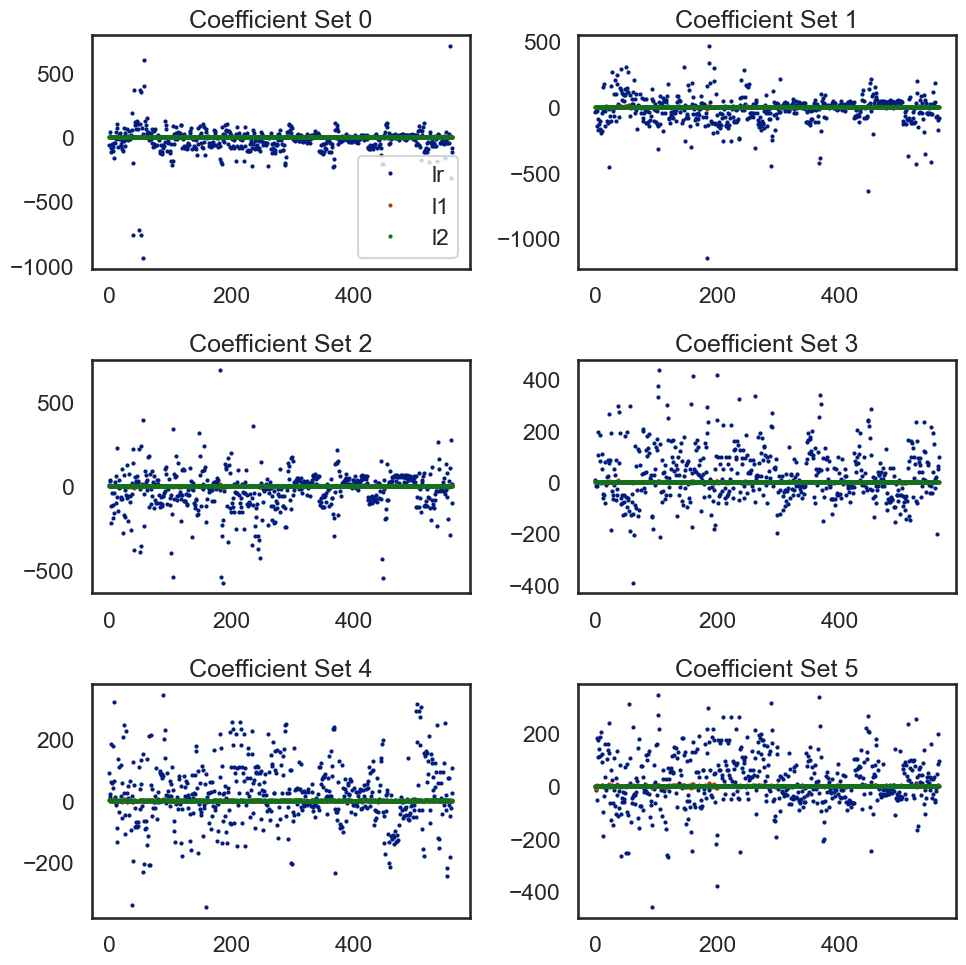

In [21]:
fig, axList = plt.subplots(nrows=3, ncols=2)
axList = axList.flatten()
fig.set_size_inches(10,10)


for ax in enumerate(axList):
    loc = ax[0]
    ax = ax[1]
    
    data_aux = coefficients.xs(loc, level=1, axis=1)
    data_aux.plot(marker='o', ls='', ms=2.0, ax=ax, legend=False)
    
    if ax is axList[0]:
        ax.legend(loc=4)
        
    ax.set(title='Coefficient Set '+str(loc))

plt.tight_layout()

## <span style="color:green">Análise Questão 5)</span>
este código cria seis gráficos separados, um para cada classe multiclasse, para visualizar as magnitudes dos coeficientes em modelos de regressão logística. Cada gráfico de dispersão representa os coeficientes de um modelo específico para a classe correspondente.

O modelo sem regularização apresentou coeficientes com magnitudes maiores em comparação aos modelos com regularização. Isso ocorre porque o modelo sem regularização não impõe restrições aos coeficientes, permitindo que eles cresçam livremente. Por outro lado, os modelos com regularização, tanto L1 quanto L2, aplicam penalidades aos coeficientes para evitar valores extremamente grandes.

## Question 6

* Predict and store the class for each model.
* Also store the probability for the predicted class for each model. 

In [22]:
# Predict the class and the probability for each

y_pred = list()
y_prob = list()

coeff_labels = ['lr', 'l1', 'l2']
coeff_models = [lr, lr_l1, lr_l2]

for lab,mod in zip(coeff_labels, coeff_models):
    y_pred.append(pd.Series(mod.predict(X_test), name=lab))
    y_prob.append(pd.Series(mod.predict_proba(X_test).max(axis=1), name=lab))
    
y_pred = pd.concat(y_pred, axis=1)
y_prob = pd.concat(y_prob, axis=1)

y_pred.head()



,lr,l1,l2
0,0,0,0
1,5,5,5
2,1,1,1
3,0,0,0
4,3,3,3


In [23]:
y_prob.head()

,lr,l1,l2
0,1.0,0.998899,0.997817
1,1.0,0.998418,0.997063
2,1.0,0.999925,0.999535
3,1.0,1.000000,1.000000
4,1.0,0.999765,0.995004


## <span style="color:green">Análise Questão 6</span>
Nesta fase, ocorre a estimativa dos valores previstos e das probabilidades associadas a cada um dos modelos.

## Question 7

For each model, calculate the following error metrics: 

* accuracy
* precision
* recall
* fscore
* confusion matrix

Decide how to combine the multi-class metrics into a single value for each model.

In [24]:
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
from sklearn.preprocessing import label_binarize

metrics = list()
cm = dict()

for lab in coeff_labels:

    # Preciision, recall, f-score from the multi-class support function
    precision, recall, fscore, _ = score(y_test, y_pred[lab], average='weighted')
    
    # The usual way to calculate accuracy
    accuracy = accuracy_score(y_test, y_pred[lab])
    
    # ROC-AUC scores can be calculated by binarizing the data
    auc = roc_auc_score(label_binarize(y_test, classes=[0,1,2,3,4,5]),
              label_binarize(y_pred[lab], classes=[0,1,2,3,4,5]), 
              average='weighted')
    
    # Last, the confusion matrix
    cm[lab] = confusion_matrix(y_test, y_pred[lab])
    
    metrics.append(pd.Series({'precision':precision, 'recall':recall, 
                              'fscore':fscore, 'accuracy':accuracy,
                              'auc':auc}, 
                             name=lab))

metrics = pd.concat(metrics, axis=1)


In [25]:
#Run the metrics
metrics

,lr,l1,l2
precision,0.979220,0.987767,0.986857
recall,0.979148,0.987761,0.986854
fscore,0.979153,0.987759,0.986853
accuracy,0.979148,0.987761,0.986854
auc,0.987281,0.992523,0.991976


## <span style="color:green">Análise Questão 7</span>

O código realiza uma avaliação abrangente do desempenho de cada modelo de classificação, calculando várias métricas de erro importantes e armazenando-as em um dataframe para análise e comparação. Notavelmente, os valores de todas essas métricas foram praticamente idênticos entre os diferentes métodos avaliados.

## Question 8

Display or plot the confusion matrix for each model.

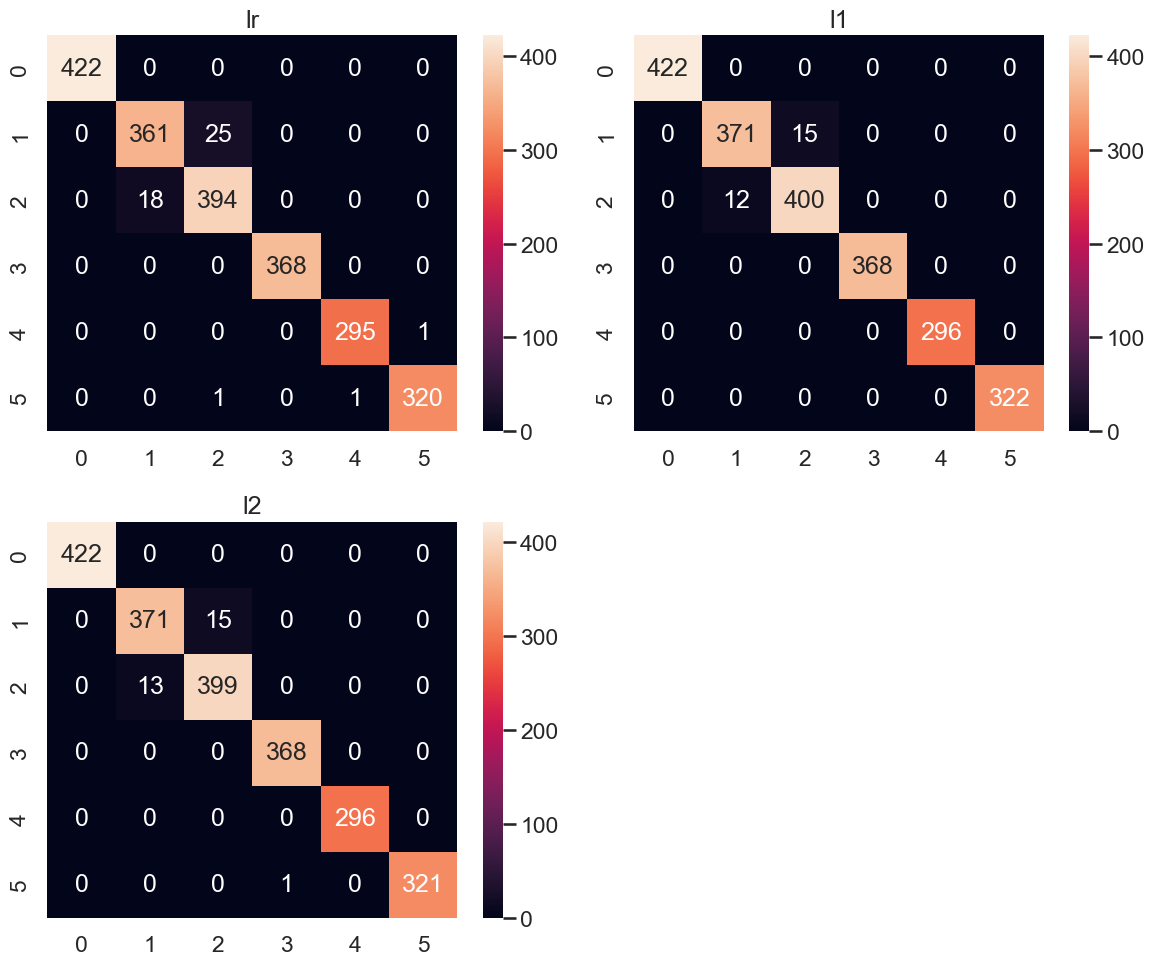

In [26]:

fig, axList = plt.subplots(nrows=2, ncols=2)
axList = axList.flatten()
fig.set_size_inches(12, 10)

axList[-1].axis('off')

for ax,lab in zip(axList[:-1], coeff_labels):
    sns.heatmap(cm[lab], ax=ax, annot=True, fmt='d');
    ax.set(title=lab);
    
plt.tight_layout()


## <span style="color:green">Análise Questão 8</span>

Esse código gera uma visualização composta por quatro subplots, cada um representando a matriz de confusão de um modelo de classificação específico. As matrizes de confusão ajudam a entender o desempenho dos modelos em termos de classificações corretas e incorretas para cada classe.

Os resultados mostram que, as classes 1 e 2 foram as que mais frequentemente resultaram em erros de previsão. Isso significa que essas duas classes têm sido desafiadoras de serem corretamente identificadas pelos modelos, e podem exigir ajustes ou melhorias para melhorar o desempenho da classificação.

## Question 9
 Identify highly correlated columns and drop those columns before building models

In [27]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import VarianceThreshold


X_data = data.iloc[:, :-1]


#threshold with .7
sel = VarianceThreshold(threshold=(.7 * (1 - .7)))
X_data = pd.DataFrame(sel.fit_transform(X_data))


feature_cols = X_data.columns[:]


# Dividindo os subjconjuntos de treino e teste, seguindo os mesmos
# Indices obtidos com Stratified Shuffle Split, agora com os dados
# Com menos features
 

X_train_new = X_data.loc[train_idx, :]

y_train_new = data.loc[train_idx, 'Activity']
 
X_test_new  = X_data.loc[test_idx, :]
y_test_new  = data.loc[test_idx, 'Activity']
 
print(X_train.shape)
print(X_train_new.shape)
 
print(X_test.shape)

(5146, 562)
(5146, 53)
(2206, 562)


 Repeat Model building with new training data after removing higly correlated columns

In [28]:
# Try standard, L1 and L2 Logistic regression

# Remoção de Colunas Altamente Correlacionadas
matriz_correlacao = X_train_new.corr().abs()
triangulo_superior = matriz_correlacao.where(np.triu(np.ones(matriz_correlacao.shape), k=1).astype(np.bool_))
a_remover = [coluna for coluna in triangulo_superior.columns if any(triangulo_superior[coluna] > 0.9)]

X_train_new = X_train_new.drop(columns=a_remover)
X_test_new = X_test_new.drop(columns=a_remover)

print(X_train.shape)
print(X_train_new.shape)
print(X_test_new.shape)

(5146, 562)
(5146, 11)
(2206, 11)


In [29]:
# Regressão Logística Padrão
regressao_logistica_padrao = LogisticRegression(max_iter=10000, penalty='none').fit(X_train_new, y_train_new)

/home/lorena/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1182: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


In [30]:
# Regressão Logística com Regularização L1 (Lasso):
regressao_logistica_lasso = LogisticRegressionCV(Cs=10, cv=4, penalty='l1', solver='liblinear', max_iter=10000).fit(X_train_new, y_train_new)

In [31]:
# Regressão Logística com Regularização L2 (Ridge):
regressao_logistica_ridge = LogisticRegressionCV(Cs=10, cv=4, penalty='l2', max_iter=10000).fit(X_train_new, y_train_new)

In [32]:
#Try with different solvers like ‘newton-cg’, ‘lbfgs’, ‘sag’, ‘saga’ and give your observations
regressao_logistica_l1_saga = LogisticRegressionCV(Cs=10, cv=4, penalty='l1', solver='saga', max_iter=1000).fit(X_train_new, y_train_new)
regressao_logistica_l2_saga = LogisticRegressionCV(Cs=10, cv=4, penalty='l2', solver='saga', max_iter=10000).fit(X_train_new, y_train_new)

/home/lorena/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lorena/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lorena/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lorena/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lorena/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lorena/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:35

In [33]:
regressao_logistica_l2_newtoncg = LogisticRegressionCV(Cs=10, cv=4, penalty='l2', solver='newton-cg', max_iter=10000).fit(X_train_new, y_train_new)
regressao_logistica_l2_sag = LogisticRegressionCV(Cs=10, cv=4, penalty='l2', solver='sag',max_iter=10000).fit(X_train_new, y_train_new)
regressao_logistica_l2_liblinear = LogisticRegressionCV(Cs=10, cv=4, penalty='l2', solver='liblinear',max_iter=10000).fit(X_train_new, y_train_new)

## Question 10

Compare the magnitudes of the coefficients for each of the models. If one-vs-rest fitting was used, each set of coefficients can be plotted separately. 

In [34]:
# Combine all the coefficients into a dataframe for comparison

coefficients_new = list()

coeff_labels_new = ['lr', 'l1', 'l2']
coeff_models_new = [regressao_logistica_padrao, regressao_logistica_lasso, regressao_logistica_ridge]

for lab,mod in zip(coeff_labels_new, coeff_models_new):
    coeffs = mod.coef_
    coeff_label = pd.MultiIndex(levels=[[lab], [0,1,2,3,4,5]], 
                                 codes=[[0,0,0,0,0,0], [0,1,2,3,4,5]])
    coefficients_new.append(pd.DataFrame(coeffs.T, columns=coeff_label))

coefficients_new = pd.concat(coefficients_new, axis=1)

coefficients_new.sample(10)

lr                                                           l1  \
           0         1          2         3         4         5         0   
7   2.260294 -3.299451  -2.303030  1.788172  0.440863  1.113152  1.494161   
0   6.134581 -8.220884 -10.588982  3.477954  6.397036  2.800296  0.075565   
9  -1.148148  0.074425   0.390820  0.181666  0.208805  0.292430  0.000000   
10 -0.183097  0.014925   0.018062  0.031198  0.068455  0.050457 -0.098399   
6  -4.124948 -2.120012  -2.485982  3.830760  1.850144  3.050038  0.111960   
3  -0.400096  0.054335   1.289878 -0.766121 -0.679864  0.501868  0.037975   
5   0.705092  0.881926   1.065334 -1.168670 -0.504065 -0.979617  0.000000   
4  -1.652185 -0.771332  -0.576513  1.185338  0.891430  0.923263  0.000000   
1  -4.317857 -5.192520  -5.218819  7.789868 -0.230306  7.169634  0.000000   
8  -2.609391  0.895313   0.851984  0.197307  0.565472  0.099315 -0.696016   

                                                            l2            \
           1         2         3         4         5         0         1   
7  -0.434924  1.613746  1.410210  0.705000  0.199370 -1.981243 -1.781679   
0  -4.467659 -8.222801  0.054797  6.452625  1.133028  0.215302 -6.372566   
9  -0.174910  0.333262 -0.056767 -0.045854  0.222188 -0.259819 -0.058061   
10 -0.005537 -0.001936 -0.019615  0.042956  0.006406 -0.145207  0.011271   
6   0.296434 -0.556499  1.998909  0.678254  0.416823 -0.909648 -2.013382   
3  -1.184800  1.264181 -0.611339 -0.048501  0.922214  0.409525 -0.376615   
5   0.000000  0.224341 -0.485998  0.406097 -0.554694  0.364935  0.799269   
4  -0.355992  0.167663  0.295361 -0.224252  0.438242 -0.108528 -0.881175   
1   0.000000 -0.004615  4.828997 -3.875936  2.885323 -1.417325 -4.454638   
8   0.000000 -0.051638 -0.177487  0.366581 -0.310199 -0.772694  0.414716   

                                            
           2         3         4         5  
7  -0.785637  2.188225  0.860390  1.499944  
0  -8.667662  4.177824  7.064430  3.582673  
9   0.254542 -0.025745 -0.001705  0.090788  
10  0.014275  0.021438  0.058376  0.039847  
6  -2.394646  2.672558  0.748052  1.897065  
3   0.856844 -0.738763 -0.644274  0.493282  
5   0.981508 -0.985915 -0.324382 -0.835415  
4  -0.688721  0.727696  0.434939  0.515789  
1  -4.504684  6.299712 -1.553741  5.630675  
8   0.371481 -0.095717  0.272510 -0.190295

Prepare six separate plots for each of the multi-class coefficients.

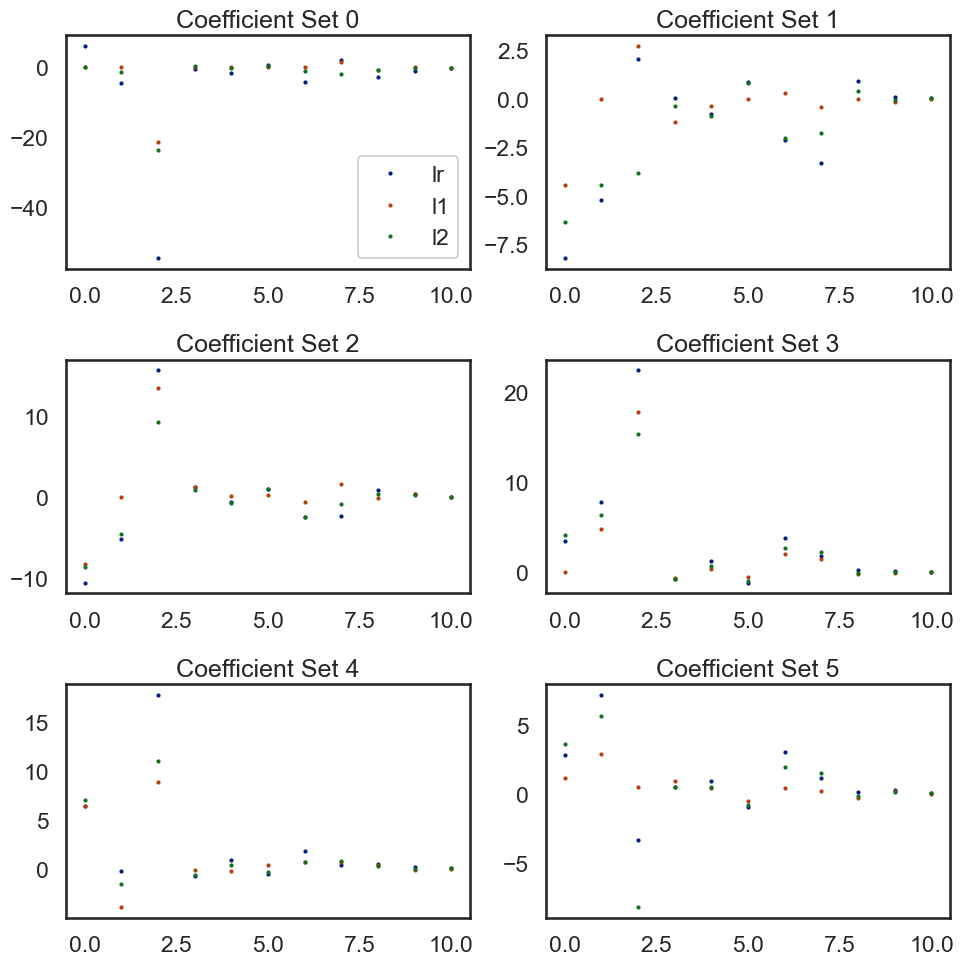

In [35]:
fig, axList = plt.subplots(nrows=3, ncols=2)
axList = axList.flatten()
fig.set_size_inches(10,10)


for ax in enumerate(axList):
    loc = ax[0]
    ax = ax[1]
    
    data_aux = coefficients_new.xs(loc, level=1, axis=1)
    data_aux.plot(marker='o', ls='', ms=2.0, ax=ax, legend=False)
    
    if ax is axList[0]:
        ax.legend(loc=4)
        
    ax.set(title='Coefficient Set '+str(loc))

plt.tight_layout()

## Question 11

* Predict and store the class for each model.
* Also store the probability for the predicted class for each model. 

In [36]:
# Predict the class and the probability for each

y_pred = list()
y_prob = list()

coeff_labels_new = ['lr', 'l1', 'l2']
coeff_models_new = [regressao_logistica_padrao, regressao_logistica_lasso, regressao_logistica_ridge]

for lab,mod in zip(coeff_labels_new, coeff_models_new):
    y_pred.append(pd.Series(mod.predict(X_test_new), name=lab))
    y_prob.append(pd.Series(mod.predict_proba(X_test_new).max(axis=1), name=lab))
    
y_pred = pd.concat(y_pred, axis=1)
y_prob = pd.concat(y_prob, axis=1)

y_pred.head()


,lr,l1,l2
0,0,0,0
1,3,3,3
2,1,1,1
3,0,0,0
4,3,3,3


In [37]:
y_prob.head()

,lr,l1,l2
0,0.999997,0.977793,0.996883
1,0.528123,0.533317,0.536350
2,0.839924,0.820958,0.838527
3,1.000000,0.990002,1.000000
4,0.553389,0.447175,0.543890


## Question 12

For each model, calculate the following error metrics: 

* accuracy
* precision
* recall
* fscore
* confusion matrix

Decide how to combine the multi-class metrics into a single value for each model.

In [38]:
# Calculate the error metrics as listed above

metrics = list()
cm_new = dict()

for lab in coeff_labels_new:

    # Preciision, recall, f-score from the multi-class support function
    precision, recall, fscore, _ = score(y_test_new, y_pred[lab], average='weighted')
    
    # The usual way to calculate accuracy
    accuracy = accuracy_score(y_test_new, y_pred[lab])
    
    # ROC-AUC scores can be calculated by binarizing the data
    auc = roc_auc_score(label_binarize(y_test_new, classes=[0,1,2,3,4,5]),
              label_binarize(y_pred[lab], classes=[0,1,2,3,4,5]), 
              average='weighted')
    
    # Last, the confusion matrix
    cm_new[lab] = confusion_matrix(y_test_new, y_pred[lab])
    
    metrics.append(pd.Series({'precision':precision, 'recall':recall, 
                              'fscore':fscore, 'accuracy':accuracy,
                              'auc':auc}, 
                             name=lab))

metrics = pd.concat(metrics, axis=1)

In [39]:
#Run the metrics
metrics

,lr,l1,l2
precision,0.766004,0.749147,0.765735
recall,0.765186,0.747053,0.764733
fscore,0.764872,0.746971,0.764415
accuracy,0.765186,0.747053,0.764733
auc,0.859695,0.848756,0.859399


## Question 13

Display or plot the confusion matrix for each model.

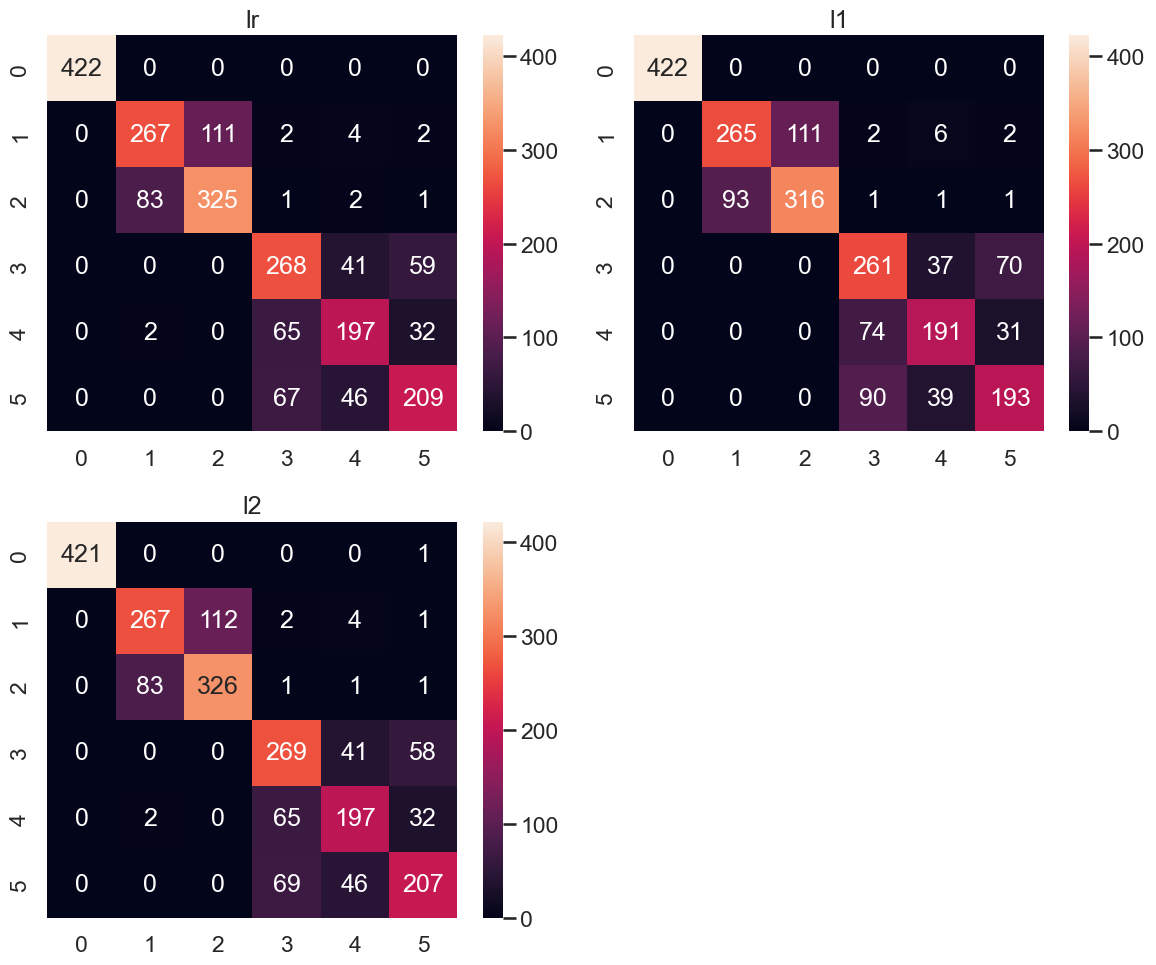

In [40]:
fig, axList = plt.subplots(nrows=2, ncols=2)
axList = axList.flatten()
fig.set_size_inches(12, 10)

axList[-1].axis('off')

for ax,lab in zip(axList[:-1], coeff_labels_new):
    sns.heatmap(cm_new[lab], ax=ax, annot=True, fmt='d');
    ax.set(title=lab);
    
plt.tight_layout()

In [41]:
# Perform a comparison of the outputs between Question 7 and 12 and give your observation

 Houve uma diminuição no desempenho geral dos modelos em termos de precision, recall, F-Score e accuracy para todas as três abordagens (lr, l1, l2). Os valores de AUC (Área sob a curva ROC) também nos resultados obtidos na questão 12, indicando uma capacidade de discriminação inferior dos modelos.

 Embora a seleção de características tenha reduzido o número de características utilizadas nos modelos, essa simplificação não resultou necessariamente em um melhor desempenho preditivo nos dados de teste. A escolha de adotar ou não a seleção de características pode depender de outros fatores.

In [42]:
# Perform a comparison of the outputs between Question 8 and 13 and give your observation

É evidente que no conjunto de dados após a seleção de características, os classificadores (com penalidade l1, l2 e sem penalidade) cometeram mais erros, destacando-se os erros nas classes 1 e 2.